# 北尾早霧・砂川武貴・山田知明『定量的マクロ経済学と数値計算』日本評論社
## 第3章：動的計画法
* ロビンソン・クルーソー経済を解く
* 3期間モデルの拡張

In [39]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import fmin, golden
import matplotlib.pyplot as plt
import japanize_matplotlib
import time

### カリブレーション
* パラメータをひとつの変数にまとめる：classを使う

In [3]:
#カリブレーション
class Params:
    """
    ロビンソン・クルーソーモデルを解くためのパラメータを含む class を定義する。
    """
    def __init__(self,β,γ,α,δ,T,nk,kmax,kmin,kgrid):
        self.β = β         # 割引因子
        self.γ = γ         # 相対的危険回避度
        self.α = α         # 資本分配率 
        self.δ = δ         # 固定資本減耗
        self.T = T         # 無人島に滞在する年数
        self.nk = nk       # 資本のグリッド数
        self.kmax = kmax   # 資本グリッドの最大値
        self.kmin = kmin   # 資本グリッドの最小値
        self.kgrid = kgrid # 資本グリッド

In [4]:
def calibration():

    β = 0.96
    γ = 1.0
    α = 0.4
    δ = 1.0
    T = 10

    nk = 11
    kmax = 1.0
    kmin = 0.05

    # numpyで等分グリッドを計算
    kgrid = np.linspace(kmin,kmax,nk)

    return Params(β, γ, α, δ, T, nk, kmax, kmin, kgrid)

In [5]:
params = calibration()

---

## 経済学でよく使う関数

In [6]:
import MyEconFcn

---

## 後ろ向きに解いていく
* **np.empty_like**は引数と同じサイズの変数を確保するための関数
* 変数の中身が初期化されていない(=どんな値が入っているか事前にはわからない)点に注意

In [7]:
# 変数を定義
pfcn = np.zeros((params.nk, params.T))
vfcn = np.empty_like(pfcn)
cfcn = np.empty_like(pfcn)
wealth = params.kgrid ** params.α

### 最終期の価値関数

In [14]:
# 最終期(全てを消費) 
# ※pythonはzero-based indexing なので 最後の要素のインデックスはTT-1である。
pfcn[:,params.T-1] = 0.0 # 全てを消費するので貯蓄はゼロ
cfcn[:,params.T-1] = params.kgrid ** params.α
vfcn[:,params.T-1] = MyEconFcn.crra(cfcn[:,params.T-1],params.γ)

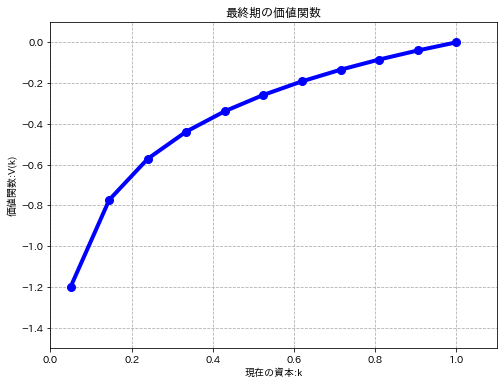

In [34]:
# 最終期の価値関数(=効用関数)を試しにプロットしてみる
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(params.kgrid, vfcn[:,-1],"-o",c="b",lw=4,ms=8) # array[-1] は julia/matlab での array[end] と同じ
ax.set(title="最終期の価値関数",xlabel="現在の資本:k",ylabel="価値関数:V(k)",xlim=(0,1.1),ylim=(-1.5,0.1))
ax.grid(ls="--")
plt.show()

### 後ろ向きに繰り返し計算
* 2.5節で学習した**最適化（optimization）**を使う

In [37]:
def BellmanEq(params,wealth,kprime,vnext):
    """
    ------------------------------------------
    === k'を1つ与えた際にベルマン方程式を返す ===
    ------------------------------------------
    <input>
    ・params: パラメータ等をまとめた変数
    ・wealth: 今期利用可能な資産
    ・kprime: 次期の資本量
    ・vnext: 補間した次期の価値関数
    <output>
    ・value: 負値にしたベルマン方程式
    """
    cons = wealth - kprime
    current_util = MyEconFcn.crra(cons,params.γ)
    value = current_util + params.β*vnext(kprime)
    value = -1*value

    return value

In [43]:
for t in reversed(range(params.T-1)): # 潜在期間について後ろから解いていく 
    
    # 次期の価値関数を補間
    vnext = interp1d(params.kgrid, vfcn[:,t+1], kind="cubic",fill_value='extrapolate') # スプライン補間 

    for i in range(params.nk): # 状態変数kについてループを行う

        BellmanEq1 = lambda kprime: BellmanEq(params,wealth[i],kprime,vnext) 
        pfcn[i,t] = golden(BellmanEq1,brack=(0.0,wealth[i])) # 最適化
        vfcn[i,t] = -BellmanEq1(pfcn[i,t]) # 最小値を探していたので符号を反転させる
    
    # 消費関数を計算
    cfcn[:,t] = params.kgrid ** params.α - pfcn[:,t]


In [44]:
def Robinson_crusoe(params):
    """
    ----------------------------------------------------------------------------------------
    === 最適化(optimization)と内挿法(interpolation)をつかってロビンソン・クルーソー経済を解く ===
    ----------------------------------------------------------------------------------------
    <input>
    ・params: パラメータを含む構造体
    <output>
    ・vfcn: 価値関数
    ・pfcn: 政策関数
    ・cfcn: 消費関数
    """

    # 変数を定義
    pfcn = np.zeros((params.nk, params.T)) # 政策関数
    vfcn = np.empty_like(pfcn) # 価値関数
    cfcn = np.empty_like(pfcn) # 消費関数
    wealth = params.kgrid ** params.α # 利用可能な資産

    # 最終期(全てを消費)
    pfcn[:,params.T-1] = 0.0 # 全てを消費するので貯蓄はゼロ
    cfcn[:,params.T-1] = np.copy(wealth)
    vfcn[:,params.T-1] = MyEconFcn.crra(cfcn[:,params.T-1],params.γ) # 消費から得られる効用

    # メインループ
    for t in reversed(range(params.T-1)): # 潜在期間について後ろから解いていく 
        
        # 次期の価値関数を補間
        vnext = interp1d(params.kgrid, vfcn[:,t+1], kind="cubic",fill_value='extrapolate') # スプライン補間 

        for i in range(params.nk): # 状態変数kについてループを行う

            BellmanEq1 = lambda kprime: BellmanEq(params,wealth[i],kprime,vnext) 
            pfcn[i,t] = golden(BellmanEq1,brack=(0.0,wealth[i])) # 最適化
            vfcn[i,t] = -BellmanEq1(pfcn[i,t]) # 最小値を探していたので符号を反転させる
    
        # 消費関数を計算
        cfcn[:,t] = params.kgrid ** params.α - pfcn[:,t]

    return vfcn, pfcn, cfcn

In [49]:
# 計算時間を計測
start = time.time()
vfcn, pfcn, cfcn = Robinson_crusoe(params)
end = time.time()

print(f"{end-start:.6f} seconds")

0.083028 seconds


---

## 計算誤差を確認するために解析的解を計算

In [52]:
# 解析的解
p_true = np.zeros((params.nk,params.T))

for t in range(params.T):
    for i in range(params.nk):
        p_true[i,t] = params.α * params.β * ((1- (params.α*params.β)**(params.T-t-1)) / (1- (params.α*params.β)**(params.T-t))) * ((params.kgrid[i] ** params.α))

---

# プロット

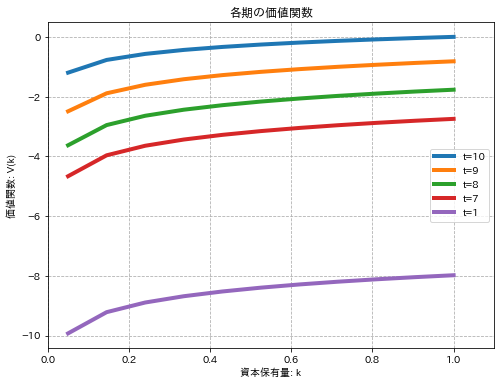

In [73]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(params.kgrid,vfcn[:,params.T-1],lw=4,label="t=10")
ax.plot(params.kgrid,vfcn[:,8],lw=4,label="t=9")
ax.plot(params.kgrid,vfcn[:,7],lw=4,label="t=8")
ax.plot(params.kgrid,vfcn[:,6],lw=4,label="t=7")
ax.plot(params.kgrid,vfcn[:,0],lw=4,label="t=1")
ax.set(xlabel=r"資本保有量: k", ylabel=r"価値関数: V(k)",title="各期の価値関数",xlim=(0,1.1))
ax.grid(ls="--")
ax.legend()
plt.show()

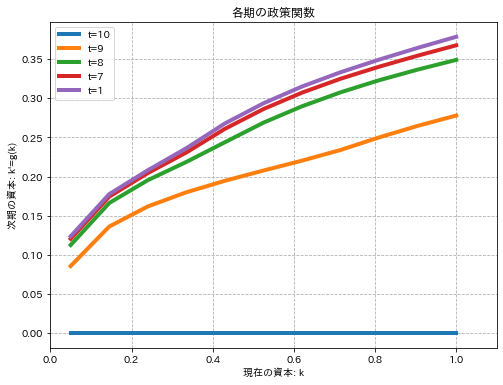

In [79]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(params.kgrid,pfcn[:,params.T-1],lw=4,label="t=10")
ax.plot(params.kgrid,pfcn[:,8],lw=4,label="t=9")
ax.plot(params.kgrid,pfcn[:,7],lw=4,label="t=8")
ax.plot(params.kgrid,pfcn[:,6],lw=4,label="t=7")
ax.plot(params.kgrid,pfcn[:,0],lw=4,label="t=1")
ax.set(xlabel="現在の資本: k", ylabel="次期の資本: k'=g(k)",title="各期の政策関数",xlim=(0,1.1))
ax.grid(ls="--")
ax.legend()
plt.show()

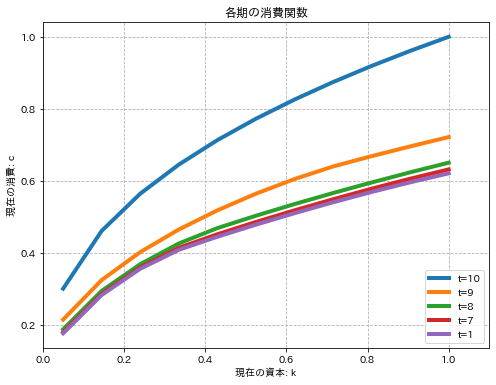

In [80]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(params.kgrid,cfcn[:,params.T-1],lw=4,label="t=10")
ax.plot(params.kgrid,cfcn[:,8],lw=4,label="t=9")
ax.plot(params.kgrid,cfcn[:,7],lw=4,label="t=8")
ax.plot(params.kgrid,cfcn[:,6],lw=4,label="t=7")
ax.plot(params.kgrid,cfcn[:,0],lw=4,label="t=1")
ax.set(xlabel="現在の資本: k", ylabel="現在の消費: c",title="各期の消費関数",xlim=(0,1.1))
ax.grid(ls="--")
ax.legend(loc="lower right")
plt.show()

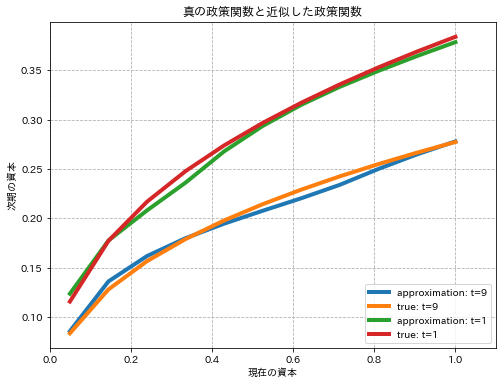

In [88]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(params.kgrid,pfcn[:,8],lw=4,label="approximation: t=9")
ax.plot(params.kgrid,p_true[:,8],lw=4,label="true: t=9")
ax.plot(params.kgrid,pfcn[:,0],lw=4,label="approximation: t=1")
ax.plot(params.kgrid,p_true[:,0],lw=4,label="true: t=1")
ax.set(xlabel="現在の資本",ylabel="次期の資本",title="真の政策関数と近似した政策関数",xlim=(0,1.1))
ax.legend(loc="lower right")
ax.grid(ls="--")
plt.show()

---

## エクササイズ
* 真の政策関数と近似した政策関数の精度があまり良くないので、改善する方法を考えてみよう。